In [9]:
import datetime
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
#import qlat as q
from scipy.optimize import curve_fit
from scipy.integrate import quad_vec
import ratios_fit

In [2]:
from importlib import reload

In [3]:
#import warnings
#warnings.filterwarnings("error")

In [4]:
from data import *
import jackknife as jk

In [5]:
Nt = 100
total_site = [1,1,1,Nt]
alpha = 1.0
beta = 20.0
barrier_strength = 100.0
M = "1.0"
L = "0.0"
t_full = 5
t_FV = "*" #65
dt = 0.2
#
version = "3-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 10000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

Loading output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_35_2024-05-28_3-1.bin
# traj: 50000
Accept rate: 0.9192096450309745
Loaded output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_35_*_3-1.bin
Loading output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_25_2024-05-28_3-1.bin
# traj: 50000
Accept rate: 0.9187853214395592
Loaded output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_25_*_3-1.bin
Loading output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_50_2024-05-28_3-1.bin
# traj: 50000
Accept rate: 0.9189184481242901
Loaded output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_50_*_3-1.bin
Loading output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_75_2024-05-28_3-1.bin
# traj: 50000
Accept rate: 0.917645603

[0.9211435329147479, 0.9487778714917959, 0.9601779682706393, 0.9869353654045755, 1.0290783917526767, 1.129415459522172, 1.303214759970364, 1.4769632119340543]


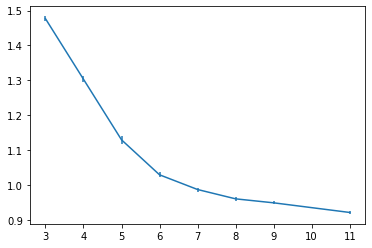

In [22]:
sfs = list(measurements.delta_actions_t_FV)
sfs.sort(key=lambda x: float(measurements.get_param(x, "tFV")))

dSs = []
dS_errs = []
t_TVs = []
        
for sf in sfs[1:]:
    blocks = measurements.get_exp_Ebar_blocks(sf)
    dS, err = jk.get_errors_from_blocks(np.mean(blocks), blocks)
    dSs.append(dS)
    dS_errs.append(err)
    t_TVs.append(measurements.get_t_TV(sf)*dt)

ratios = []
for i in range(len(dSs)):
    #t_TVs.append(t_TV_tdse[i][0])
    #ratios.append(corr_tdse[i][1]/corr_tdse[i][0])
    ratios.append(dSs[i])

plt.errorbar(t_TVs, dSs, yerr=dS_errs)
print(dSs)

[inf inf]
E0: 2.1948114177466547, sigma: 0.25240293595800767
0.8407822520890842


/home/joshua/Joshua/School/Research/Qlattice/applications/false-vacuum-decay/ratios_fit.py:114: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(self.fit, ts, data, sigma=errs, p0=[1.0, 1.0], jac=self.dfit, bounds=((-np.inf,0),(np.inf,np.inf)), full_output=full_output)


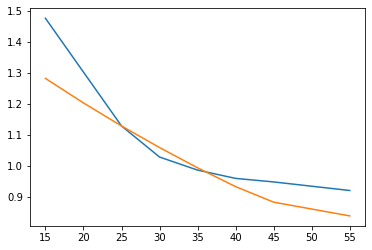

In [7]:
fit = ratios_fit.GaussianFitNoBounds(0.2)

start=5
end=-2
opt, cov = fit.get_fit_params(t_TVs[start:end], ratios[start:end], dS_errs[start:end])
print(np.sqrt(np.diag(cov)))

plt.plot(t_TVs, ratios)
plt.plot(t_TVs, fit.fit(np.array(t_TVs), opt[0], opt[1]))
#plt.plot(t_TVs, fit2(np.array(t_TVs), opt2[0], opt2[1],opt2[2]))
print(f"E0: {opt[0]}, sigma: {opt[1]}")
print(fit.get_correction(30,*opt))

Start fit from time 4.0
E_FV: 0.5678512089471415, E0: 4.6373438162889755, sigma: 0.9426418348176712
0.7224113863937398
3.428553026541766


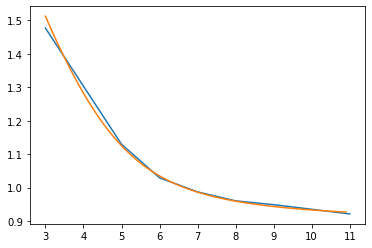

In [24]:
ratios_fit = reload(ratios_fit)
fit = ratios_fit.GaussianFit(dt)
#t_start = fit.choose_start(t_TVs, ratios, dS_errs)
t_start = 20*dt
print(f"Start fit from time {t_start}")

end = t_TVs.index(t_start)
opt, cov = fit.get_fit_params(t_TVs[:end], ratios[:end], dS_errs[:end])
#print(np.sqrt(np.diag(cov)))

plt.plot(t_TVs, ratios)
plt.plot(np.arange(t_TVs[-1],t_TVs[0],0.1), fit.fit(np.arange(t_TVs[-1],t_TVs[0],0.1), opt[0], opt[1],opt[2]))
#plt.plot(t_TVs, fit2(np.array(t_TVs), opt2[0], opt2[1],opt2[2]))
print(f"E_FV: {opt[0]}, E0: {opt[1]}, sigma: {opt[2]}")
print(fit.get_correction(6,*opt))

dist = lambda E: fit.integrand(E, 6, t_start, opt[0], opt[1], opt[2])
print(quad_vec(lambda E: (E+opt[0])*dist(E), -opt[0], np.inf)[0]/quad_vec(dist, -opt[0], np.inf)[0])

fit_g = fit
opt_g = opt

In [25]:
profile_tFV  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full}_tFV_*_*_*"
a,b,pfit_from_mean, power_blocks = measurements.get_fit_ratios_blocks(profile_tFV, 30, start=0, fitobject=ratios_fit.PowerFit)

Based on mean, ratios fit is: 0.854498026082723


In [20]:
profile_tFV  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full}_tFV_*_*_*"
X, Y, gfit_from_mean, gaus_blocks = measurements.get_fit_ratios_blocks(profile_tFV, 30, start=25, stop=55)

Based on mean, ratios fit is: 0.9890004692053752


In [26]:
#jk.get_errors_from_blocks(np.mean(blocks), blocks)
print(jk.get_errors_from_blocks(gfit_from_mean, gaus_blocks))
print(jk.get_errors_from_blocks(pfit_from_mean, power_blocks))

[1.0614118697223378, 0.2197809184008901]
[0.8530685572395232, 0.07242032780961935]


[2.72175285 0.02333589 4.69220596 0.11014319]
start_time: -2.6665599930885446, E_FV: 0.4266659681329399, n: 19.70067652326793
2.150492895607927


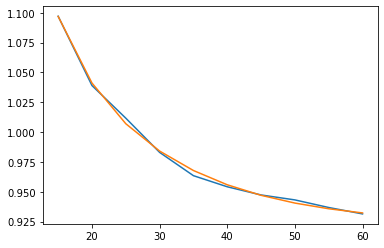

In [9]:
ratios_fit=reload(ratios_fit)
fit = ratios_fit.PowerFit2(0.2)
#print(fit.choose_start(t_TVs, ratios, dS_errs))

start = 0
end = 100 #t_TVs.index(5)
opt, cov = fit.get_fit_params(t_TVs[start:end], ratios[start:end], dS_errs[start:end])

print(np.sqrt(np.diag(cov)))

plt.plot(t_TVs, ratios)
plt.plot(t_TVs, fit.fit(np.array(t_TVs), *opt))
print(f"start_time: {opt[0]}, E_FV: {opt[1]}, n: {opt[2]}")
print(fit.get_correction(30,*opt))

fit_power = fit
opt_power = opt

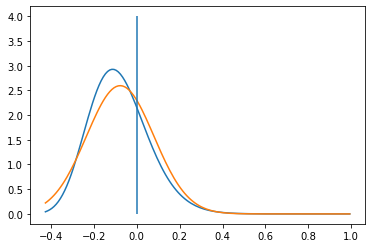

In [37]:
t = 30.0
E = np.arange(-opt_power[1],1,0.01)
plt.plot(E, [fit_power.integrand(E[i],np.array([t]),*opt_power)[0] for i in range(len(E))]/fit_power.Rt(np.array([t]),*opt_power))

plt.plot(E, [fit_g.integrand(E[i],np.array([t]),fit_g.start_time,opt_g[0],opt_g[1],opt_g[2])[0] for i in range(len(E))]/fit_g.Rt(np.array([t]),fit_g.start_time,opt_g[0],opt_g[1],opt_g[2]))
plt.vlines([0.0], 0.0, 4.0)

# Changing $t_\text{full}$

In [5]:
Nt = 100
total_site = [1,1,1,Nt]
alpha = 1.0
beta = 20.0
barrier_strength = 100.0
M = "*"
L = "*"
t_full = 5
t_FV = 60
dt = 0.2
#
version = "3-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{0.01}_v0_{3.0}_alpha_{0.0}_m_{1.0}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 10000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

Loading output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_1.0_tfull_5_tFV_60_2024-05-28_3-1.bin
# traj: 50000
Accept rate: 0.9179118692918327
Loaded output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_1.0_tfull_5_tFV_60_*_3-1.bin
Loading output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.256_tfull_5_tFV_60_2024-05-28_3-1.bin
# traj: 50000
Accept rate: 0.9161070238216642
Loaded output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.256_tfull_5_tFV_60_*_3-1.bin
Loading output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.002_tfull_5_tFV_60_2024-05-28_3-1.bin
# traj: 50000
Accept rate: 0.918700378812857
Loaded output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.002_tfull_5_tFV_60_*_3-1.bin
Loading output_data/measurements_1x100_alpha_1.0_beta_20.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_60_2024-05-28_3-1.bin
# traj: 50000
Accept rate: 0.91

In [6]:
Ms = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
profile_ML = f"output_data/measurements_{fileid}.bin"

ml_blocks = measurements.get_M_L_blocks(Ms, Ls, profile_ML)
R_blocks = jk.super_jackknife_combine_blocks(ml_blocks, lambda x: measurements.calc_ratio(x, len(Ms)-1))
jk.get_errors_from_blocks(np.mean(R_blocks), R_blocks)

[2.769763556804075e-10, 1.8579130417724152e-11]

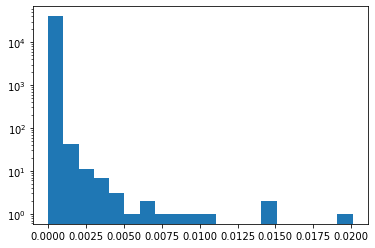

In [86]:
sfs = measurements.replace_params(profile_ML, ["M", "L"], [[0.128, 1.0]])
for sf in sfs:
    a = np.exp(measurements.delta_actions_M[sf][f"0.256"][measurements.cutoff:])
    plt.hist(a[:], bins=20)
    plt.yscale("log")

[6.40821350e-06 1.68212885e+00]


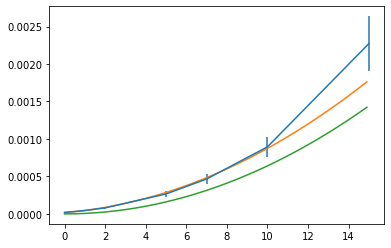

In [19]:
t = [0, 1, 2, 5, 7, 10, 15]
R = [1.9325564090891424e-05, 4.507398632625518e-05, 8.074689508988359e-05, 0.0002662934489756581, 0.00046580201801283013, 0.0008946857327069169, 0.0022725578364517873]
R_err = [2.6651406798190626e-06, 6.316515688423676e-06, 1.1390259997472873e-05, 4.0396227507911365e-05, 6.737820785562193e-05, 0.00013266703652616086, 0.0003646535178961716]

#f=lambda t, A, B: A*np.power(t+B,2)
f=lambda t, A, B: A*np.power(t+B,2)
opt, cov = curve_fit(f, t[:10], R[:10], sigma=R_err[:10])

end = 8
plt.errorbar(t[:end], R[:end], yerr=R_err[:end])

t=np.arange(0,15, 0.1)
fit = lambda t: f(t,opt[0],opt[1])
plt.plot(t, fit(t))
corrected_fit = lambda t: f(t,opt[0],0)
plt.plot(t, corrected_fit(t))
print(opt)
#print(opt[0], 2*opt[0]*opt[1], opt[0]*opt[1]**2)

# Calculating the Decay Rate

In [30]:
Nt = 100
total_site = [1,1,1,Nt]
alpha = 0.6
beta = 20.0
barrier_strength = 100.0
M = "*"
L = "*"
t_full = 5
t_FV = "*" #65
dt = 0.2
#
version = "3-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{0.01}_v0_{3.5}_alpha_{0.0}_m_{1.0}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 2000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

Loading output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_35_2024-05-27_3-1.bin
# traj: 50000
Accept rate: 0.7947499656721105
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_35_*_3-1.bin
Loading output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.016_L_1.0_tfull_5_tFV_60_2024-05-27_3-1.bin
# traj: 50000
Accept rate: 0.8608987733648119
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.016_L_1.0_tfull_5_tFV_60_*_3-1.bin
Loading output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.064_L_1.0_tfull_5_tFV_60_2024-05-27_3-1.bin
# traj: 50000
Accept rate: 0.8559494699676661
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.064_L_1.0_tfull_5_tFV_60_*_3-1.bin
Loading output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.002_tfull_5_tFV_60_2024-05-27_3-1.bin
# traj: 50000
Accept rate: 0

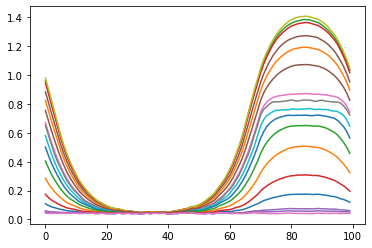

In [31]:
profile_tFV  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full}_tFV_{t_FV}_*_{version}.bin"
#profile_tFV = f"output_data/measurements_{total_site[0]}x{total_site[3]}_lmbd_{0.01}_v0_{3.5}_alpha_{0.0}_m_{1.0}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full}_tFV_{t_FV}_*_{version}.bin"
tFV_ML = 60
profile_ML  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_*_L_*_tfull_{t_full}_tFV_{tFV_ML}_*_{version}.bin"
#profile_ML = f"output_data/measurements_{total_site[0]}x{total_site[3]}_lmbd_{0.01}_v0_{3.5}_alpha_{0.0}_m_{1.0}_dt_{dt}_bar_{barrier_strength}_M_*_L_*_tfull_{t_full}_tFV_{tFV_ML}_*_{version}.bin"

measurements.plot_mean_path(profile_ML)
#plt.legend()
#fig = plt.gcf()
#fig.set_size_inches(20, 10)
plt.show()

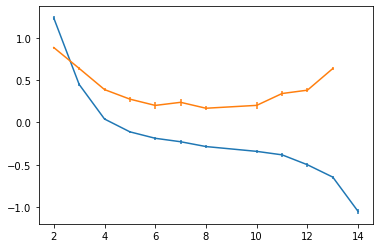

In [32]:
measurements.plot_Ebar_E_FV(profile_tFV)
measurements.plot_Ebar_slope(profile_tFV)

In [33]:
Ms = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.256, 0.512, 1.0]
gamma, gamma_err = measurements.calc_gamma_w_errors(Ms, Ls, profile_ML, profile_tFV, der=0)
print(gamma, gamma_err)

Calculating dE with t_FV=60 and t_FV=65
Correction factor estimated: 1.1500223581076063
4.167971138852795e-05 3.437454083061482e-06


1.0, 9:
Correction factor estimated: 1.025827867304916
0.0006043145783269966 3.64574470652222e-05


1.0, 20:
Correction factor estimated: 0.5722111566538117
7.982921290721122e-10 3.9595361594463895e-11

0.6, 20:
Correction factor estimated: 1.1500223581076063
1.7063537029990565e-05 1.186991149884568e-06

In [48]:
gammas_M_L = measurements.calc_gamma_M_L_errors(Ms,Ls,profile_ML, profile_tFV)

Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65
Calculating dE with t_FV=55 and t_FV=65


[4.502822367180153e-05, 4.5030990329621024e-05, 4.461327890259885e-05, 4.3990494262164655e-05, 4.353529922483827e-05, 4.677878324826094e-05, 4.063270632839597e-05, 4.501390745211707e-05, 4.5234002934942905e-05, 4.527533877887866e-05, 4.478027561042627e-05, 4.516460748276308e-05, 4.2661901702656786e-05, 4.52703791301266e-05]


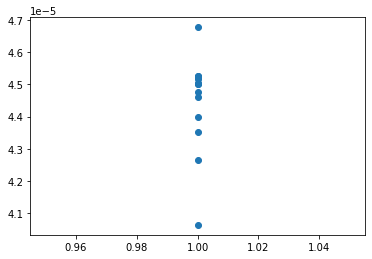

In [49]:
plt.scatter([1]*len(gammas_M_L), [gammas_M_L[i] for i in range(len(gammas_M_L))])
print(gammas_M_L)

In [21]:
l_err, u_err = measurements.calc_gamma_dis_errors(Ms,Ls,profile_ML, profile_tFV)
print(l_err, u_err)

Calculating dE with t_FV=60 and t_FV=70
Calculating dE with t_FV=60 and t_FV=65
Calculating dE with t_FV=65 and t_FV=70
7.856115035859276e-05 9.032834088495457e-05


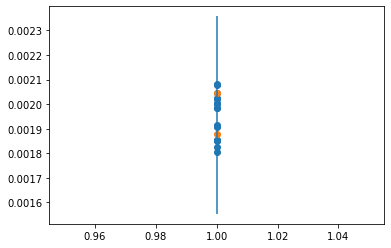

In [22]:
plt.errorbar([1.0], [gamma], [gamma_err])
plt.scatter([1.0]*len(gammas_M_L), [gammas_M_L[i] for i in range(len(gammas_M_L))])
plt.scatter([1.0]*2, [gamma+u_err, gamma-l_err])

In [ ]:
0.0018729202417479005, 0.000389280560521738
0.0020105263780584417, 0.0005082331894344297
0.002804109507570317, 0.0005700302060932646

**Systematic errors:**
- Discretization error in determining $\Delta E$ from the slope of $\bar{E}$
- Systematic bias when calculuting ratios

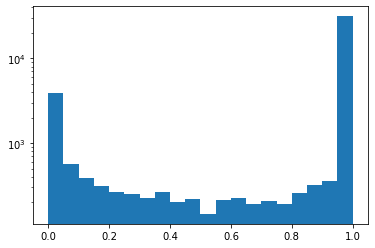

In [57]:
sf = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_65_*_1-1.bin"
t_TV = measurements.get_t_TV(sf)
a = np.array(np.exp(measurements.delta_actions_t_TV[sf][f"{t_TV+1}"][measurements.cutoff:]))
plt.hist(a[a>-15], bins=20)
plt.yscale("log")

2.4248795963573606

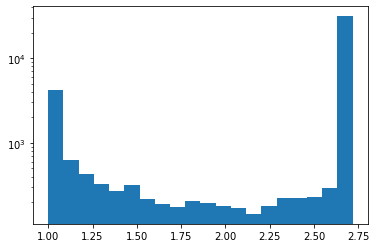

In [58]:
plt.hist(np.exp(a[a>-50]), bins=20)
plt.yscale("log")
np.mean(np.exp(a[a>-15]))

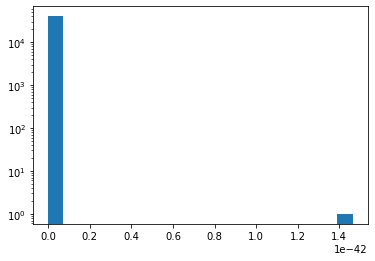

In [54]:
sf = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_65_*_1-1.bin"
t_TV = measurements.get_t_TV(sf)
a = np.exp(measurements.delta_actions_M[sf][f"0.512"][measurements.cutoff:])
plt.hist(a[a<1e-1], bins=20)
plt.yscale("log")
#plt.xscale("log")

**Old code:**

In [13]:
sf = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_*_1-1.bin"
Ebar = measurements.get_Ebar_E_FV(sf)
print(Ebar)

[-0.07925521899146061, 0.0747078765790698]


In [14]:
sf1 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_*_1-1.bin"
sf2 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_55_*_1-1.bin"
delta_E = measurements.get_Ebar_slope(sf1, sf2)
print(delta_E)

[0.24658002974604404, 0.06983637299327515]


In [15]:
sf1 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_65_*_1-1.bin"
sf2 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_55_*_1-1.bin"
delta_E = measurements.get_Ebar_slope(sf1, sf2)
print(delta_E)

[0.2883725302516306, 0.04876960693493655]


In [10]:
Ms = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
sf0 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_60_*_1-1.bin"
da_blocks = measurements.get_M_L_blocks(Ms, Ls, sf0)
ratio=measurements.calc_ratio(da_blocks, len(Ms)-1)
blocks = jk.super_jackknife_combine_blocks(da_blocks, lambda x: measurements.calc_ratio(x, len(Ms)-1))
jk.get_errors_from_blocks(ratio, blocks)

[0.00029132200314709055, 5.222914895353905e-05]

In [16]:
measurements.calc_gamma(ratio, Ebar[0], delta_E[0], 5, 0.2)

0.002450739789529811

In [27]:
measurements.calc_gamma(corrected_fit(5), Ebar[0], delta_E[0], 5, 0.2)

0.0020455287419108114

# Calculating $\bar{E}$ and $\Delta E$

Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_75_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_65_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_70_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_85_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_55_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_80_*_1-1.bin


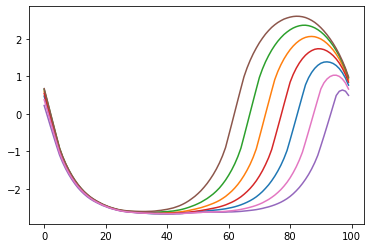

In [12]:
Nt = 100
total_site = [1,1,1,Nt]
lmbd = 0.01
v0 = 3.0
alpha = 0.0
barrier_strength = 100.0
M = "1.0"
L = "0.0"
t_full = "5"
t_FV = "*"
m_particle = 1.0
dt = 0.2
#
version = "1-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 2000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

measurements.plot_mean_path()
plt.show()

## TDSE Calculations for $\bar{E}$ and $\Delta E$

[0.38320387088209507, 0.19998760952050332, 0.07152787017714676, -0.018307282199245094, -0.08058611319964533]
[0.42803769 0.35841281 0.29972513 0.24955727]


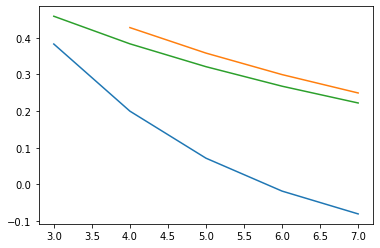

In [4]:
t_full_tdse = 1.0
t_total_tdse = 20.0
t_FV_tdse = [[7.5, 7.6, 6.4], 
             [7.0, 7.1, 6.9], 
             [6.5, 6.6, 6.4], 
             [6.0, 6.1, 5.9], 
             [5.5, 5.6, 5.4]]
t_FV_tdse = np.multiply(t_FV_tdse,2)
t_TV_tdse = [[1.5, 1.4, 1.6], 
             [2.0, 1.9, 2.1], 
             [2.5, 2.4, 2.6], 
             [3.0, 2.9, 3.1], 
             [3.5, 3.4, 3.6]]
t_TV_tdse = np.multiply(t_TV_tdse,2)
corr_tdse = [[8.248663373196439e-08, 8.905703783595409e-08, 7.704757642858247e-08],
             [6.309382431172544e-08, 6.566856939543131e-08, 6.097811910246092e-08],
             [5.599952880841047e-08, 5.680639177237058e-08, 5.543258059759522e-08],
             [5.51639432842981e-08, 5.4962332229197884e-08, 5.5525637075399806e-08],
             [5.8430364009058354e-08, 5.7496177293354066e-08, 5.9497150195223996e-08]]
corr0 = 0.0002828628961749551 # Correlation function when only H_FV is used

def plot_E_tdse(j=1):
    E_t_TV_tdse = []
    E_tdse = []
    for i in range(len(corr_tdse)):
        E_t_TV_tdse.append(t_TV_tdse[i][0])
        E_tdse.append(np.log(corr_tdse[i][j]/corr_tdse[i][0])/(t_TV_tdse[i][0]-t_TV_tdse[i][j]))
    plt.plot(E_t_TV_tdse, E_tdse)
    print(E_tdse)

def plot_slope_tdse(j=1):
    E_t_TV_tdse = []
    E_tdse = []
    for i in range(len(corr_tdse)):
        E_t_TV_tdse.append(t_TV_tdse[i][0])
        E_tdse.append(np.log(corr_tdse[i][j]/corr_tdse[i][0])/(t_TV_tdse[i][0]-t_TV_tdse[i][j]))
    plt.plot(E_t_TV_tdse[1:], (-np.subtract(E_tdse[1:], E_tdse[:-1])/np.subtract(E_t_TV_tdse[1:],E_t_TV_tdse[:-1]))**0.5)
    print((-np.subtract(E_tdse[1:], E_tdse[:-1])/np.subtract(E_t_TV_tdse[1:],E_t_TV_tdse[:-1]))**0.5)

def plot_delta_E_tdse(j=1):
    E_t_TV_tdse = []
    E_tdse = []
    for i in range(len(corr_tdse)):
        E_t_TV_tdse.append(t_TV_tdse[i][0])
        E_tdse.append(np.log(corr_tdse[i][1]*corr_tdse[i][2]/corr_tdse[i][0]**2)**0.5/(t_TV_tdse[i][0]-t_TV_tdse[i][1]))
    plt.plot(E_t_TV_tdse, E_tdse)

plot_E_tdse()
plot_slope_tdse()
plot_delta_E_tdse()

In [14]:
R = 5.599952880841047e-08/corr0
print(f"R: {R}")
dE = 0.29972513
Ebar_m_E_FV = 0.07152787017714676

print(R*(2*np.pi)**0.5/dE * np.exp(-(Ebar_m_E_FV)**2/2/dE**2)/(5*0.2)**2)

R: 0.00019797410535517493
0.0016091937249886627


## Calculating $\bar{E}$

[0.38320387088209507, 0.19998760952050332, 0.07152787017714676, -0.018307282199245094, -0.08058611319964533]
[0.34106579050817015, 0.17053898362684042, 0.05087879121495884, -0.032676524498533574, -0.09046364573722997]


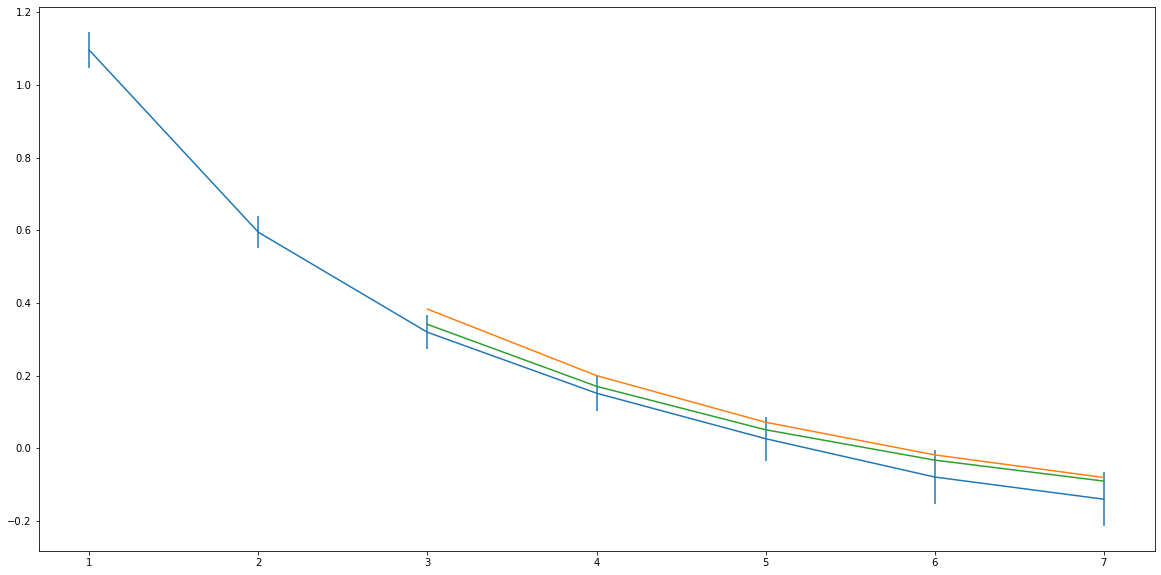

In [19]:
measurements.cutoff = 10000
measurements.block_size = 2000
measurements.plot_Ebar_E_FV(1)
#measurements.plot_Ebar_E_FV(2)
#measurements.plot_Ebar_E_FV(-2)
#measurements2.plot_Ebar_E_FV(-2)
plot_E_tdse()
plot_E_tdse(2)
#plt.xlim(8,42)
#plt.ylim(-0.7,0.7)

fig = plt.gcf()
fig.set_size_inches(20, 10)

## Calculating $\Delta E$

[0.42803769 0.35841281 0.29972513 0.24955727]


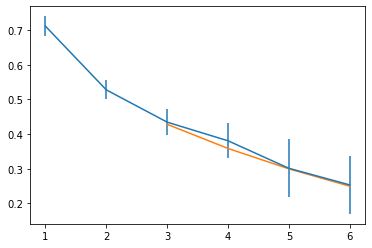

In [16]:
measurements.plot_Ebar_slope()
plot_slope_tdse()

## Analytic Calculation Based on Initial Ansatz

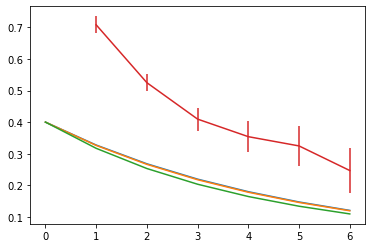

In [8]:
m_particle = 1.0
E0 = 0.4
Gamma = 0.0015
def E_dist(E,t):
    return 1/((E-E0)**2+Gamma**2/4.0)*np.exp(-E*t)

dE = 0.0001
Es=np.arange(0,2*E0,dE)
#plt.plot(Es, E_dist(Es,4.0))

def get_delta_E(t):
    return (np.sum(E_dist(Es,t)*Es**2)*dE)**0.5

def plot_delta_Es():
    dEs=[]
    for t in np.arange(0,7,1):
        dEs.append(get_delta_E(t))
    plt.plot(np.divide(dEs,2.5*dEs[0]))

plot_delta_Es()
Gamma = 0.015
plot_delta_Es()
Gamma = 0.15
plot_delta_Es()
measurements.plot_Ebar_slope()
#plot_half_slope_tdse()

## Obserable Distribution

[0.31928225666093996, 0.0466713256630312]
0.319282256660941


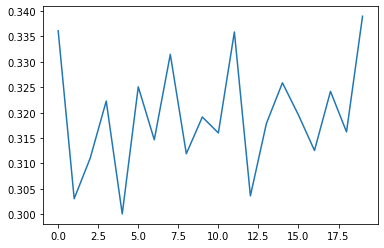

In [50]:
measurements.block_size = 2000
measurements.cutoff=10000

t_TV = measurements.get_t_TV(sf)
t_FV = int(measurements.get_param(sf,"tFV"))
dt = float(measurements.get_param(sf, "dt"))

blocks_TV = jk.get_jackknife_blocks(np.exp(measurements.delta_actions_t_TV[sf][f"{t_TV+1}"][measurements.cutoff:]), measurements.block_size)
blocks_FV = jk.get_jackknife_blocks(np.exp(measurements.delta_actions_t_FV[sf][f"{t_FV+1}"][measurements.cutoff:]), measurements.block_size)
bdiv = np.log(np.divide(blocks_FV,blocks_TV))/(dt*1)

#plt.plot(np.exp(measurements.delta_actions_t_FV[sf][f"{t_FV+1}"][measurements.cutoff:measurements.cutoff+100]))
plt.plot(bdiv[:])
print(jk.get_errors_from_blocks(np.mean(bdiv), bdiv))
print(np.mean(bdiv))

# Changing M and L

In [7]:
Nt = 100
total_site = [1,1,1,Nt]
alpha = 0.6
beta = 20.0
barrier_strength = 100.0
M = "*"
L = "*"
t_full = 5
t_FV = 60
dt = 0.2
#
version = "3-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 2000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.016_L_1.0_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.8608987733648119
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.064_L_1.0_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.8559494699676661
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.002_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.8011887194299901
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.004_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.7999942721396615
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.002_L_1.0_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.861121361658655
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.016_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.7976642116857925
Loaded output_data/measurements_1x100_alp

In [27]:
#for M in np.arange(0.0, 1.0, 0.001):
#    fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{round(M,5)}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#    measurements.load(f"output_data/measurements_{fileid}.bin")

In [28]:
#M = 1.0
#for L in np.arange(0.0, 1.0, 0.001):
#    fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{round(L,5)}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#    measurements.load(f"output_data/measurements_{fileid}.bin")

output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_60_*_3-1.bin
No previous factor found for M=0.0
[0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512]
[0.4988246853274199, 0.2551145494227235, 0.07178862495247165, 0.0075162482033356215, 0.00022261829123066128, 2.8987226378867073e-06, 1.5816597285929933e-08, 3.3774160802167156e-12, 3.7488426295116393e-19]
[0.0004957345099183301, 0.0005342017345603138, 0.0003320232066383379, 8.46324466526588e-05, 8.735223127772413e-06, 5.843690226122213e-07, 8.910705384460113e-09, 3.044653293256373e-12, 3.7342674707618433e-19]
output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.002_L_1.0_tfull_5_tFV_60_*_3-1.bin
[0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
[0.25509296248329716, 0.071776290700138, 0.007515961383716473, 0.0002232103571726112, 3.075316577618656e-06, 2.4261232021929398e-08, 1.2757965461543315e-11, 9.05542083534448e-18, 2.1610648244249003e-29]
[0.00025230

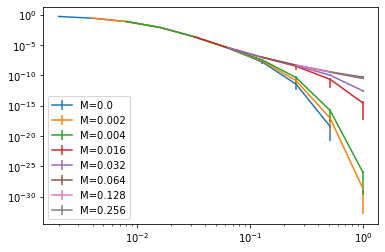

In [8]:
measurements.plot_expS_vs_M()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_*_3-1.bin
No previous factor found for L=0.0
[0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512]
[0.7034571107697758, 0.5071910841972777, 0.2797849925836887, 0.10159331755055567, 0.021419161754138993, 0.0029268374783120842, 0.0004352897090345533, 8.602142287919883e-05, 1.505623455269142e-05]
[0.0012220448315693997, 0.0016114479856148393, 0.0015414830622522842, 0.0009432172281383515, 0.00038774473606395716, 0.00014048675015786377, 6.274486729019664e-05, 2.5687016023419872e-05, 6.024564258690065e-06]
output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.002_tfull_5_tFV_60_*_3-1.bin
[0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
[0.507072539578227, 0.2795923921878675, 0.10153224724956832, 0.021504248934830272, 0.0029663614664413467, 0.0004222455187691606, 6.965905840808419e-05, 9.434374750132762e-06, 7.42092080965098e-07]
[0.0006477424203280192,

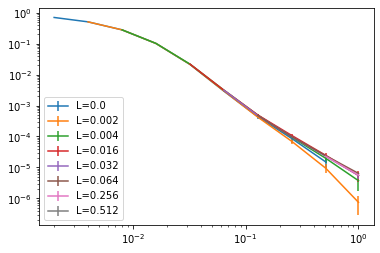

In [9]:
measurements.plot_expS_vs_L()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [10]:
Ms = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
sf0 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_65_*_1-1.bin"
da_list = measurements.get_M_L_list(Ms, Ls, sf0)
ratio=measurements.calc_ratio(da_list, len(Ms)-1)
print(ratio)

AttributeError: 'Data' object has no attribute 'get_M_L_list'

In [17]:
blocks = jk.get_super_jackknife_blocks(da_list, 1000, lambda x: measurements.calc_ratio(x, len(Ms)-1))
jk.get_errors_from_blocks(ratio, blocks)

[0.0002653559844209393, 3.800391252415348e-05]

In [ ]:
[0.0002653559844209393, 3.800391252415348e-05]